In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
from copy import deepcopy

# from pymatgen.core import Structure
# from pymatgen.io.vasp.outputs import Vasprun
# from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer
# from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis, EvolutionAnalyzer

from sklearn.linear_model import LinearRegression 

# PCF

In [4]:
file = open('MD-VASP/v2/LLZO_Ia3d_Al20_run0/PCDAT', 'r')
lines = file.readlines()
pcskal = float(lines[8])
pcfein = float(lines[9])
PCF = lines[12:]
PCF = np.array(PCF, dtype='float')
r = np.arange(PCF.size)*(pcskal/pcfein)*1e10
file.close()

[]


ValueError: min() arg is an empty sequence

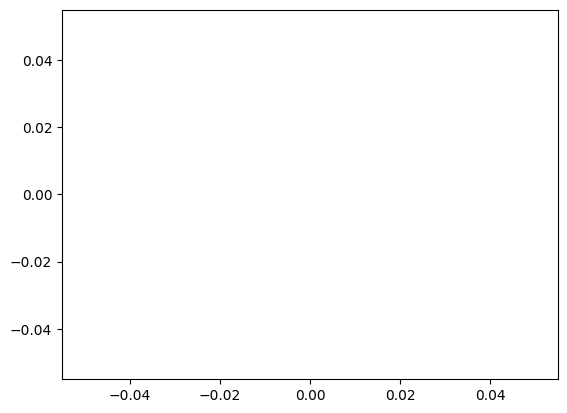

In [3]:
plt.plot(r, PCF)
plt.plot([min(r), max(r)], [1, 1], color='black')
plt.xlabel('Radial Distance (angstroms)')
plt.xlim([min(r), max(r)])
plt.ylim([min(PCF), max(PCF)+.1])
plt.ylabel('PCF')
plt.title('Pair Correlation Function')
plt.axvline(1.38, color='black')
plt.show()

# Relaxation Convergence

Text(0, 0.5, 'Potential Energy (eV)')

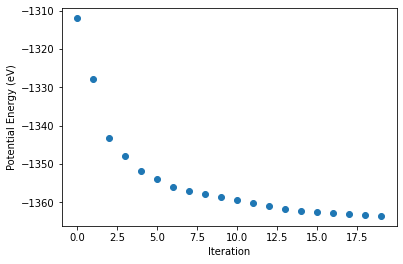

In [4]:
with open('Relaxation/LLZO_Ia3d_Al30_initial/LLZO_Ia3d_Al30_partial_relaxed/LLZO_Ia3d_Al30_partial_00.vasp_output', 'r') as f:
    lines = f.readlines()
E_conv = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))

plt.scatter(range(len(E_conv)), E_conv)
plt.xlabel('Iteration')
plt.ylabel('Potential Energy (eV)')

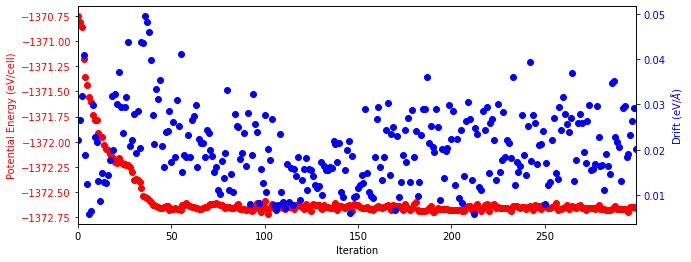

In [2]:
file = open('Relaxation/LLZO_Ia3d_Al00/output_file')
lines = file.readlines()
E = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E = np.append(E, float(values[4]) * 10**float(values[5]))
file.close()

file = open('Relaxation/LLZO_Ia3d_Al00/OUTCAR')
lines = file.readlines()
drift = np.array([])
for line in lines:
    if 'total drift' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        drift = np.append(drift, np.sqrt(float(values[0])**2 + float(values[1])**2 + float(values[1])**2))
file.close()

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.scatter(range(len(E)), E, color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Potential Energy (eV/cell)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.scatter(range(len(drift)), drift, color='blue')
ax2.set_ylabel(r'Drift (eV/$\AA$)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.autoscale(enable=True, axis='x', tight=True)

plt.show()

# Structure Selection

23
97


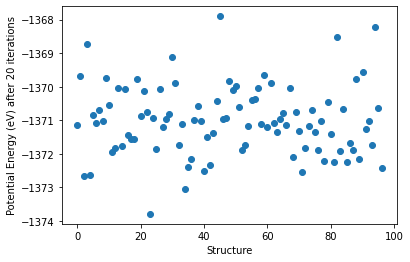

In [2]:
E = np.array([])
for file in sorted(glob.glob('Relaxation/LLZO_Ia3d_Al00_initial/LLZO_Ia3d_Al00_partial_relaxed/LLZO_Ia3d_Al00_partial_*.vasp_output')):
    with open(file, 'r') as f:
        lines = f.readlines()
    E_conv = np.array([])
    for line in lines:
        if 'E0=' in line:
            values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))
    if len(E_conv) > 0:
        E = np.append(E, E_conv[-1])
    else:
        continue
plt.scatter(range(len(E)), E)
plt.xlabel('Structure')
plt.ylabel('Potential Energy (eV) after 20 iterations')
print(np.argmin(E))
print(len(E))

# Testing VASP File Writing

In [17]:
import numpy as np

from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.transformations.standard_transformations import DiscretizeOccupanciesTransformation
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation
from pymatgen.transformations.standard_transformations import RemoveSpeciesTransformation
from pymatgen.transformations.advanced_transformations import SQSTransformation

### Manually edit original .cif file

In [20]:
structure = Structure.from_file(filename='structure_files/LLZO_Ia3d_experimental.cif')
analyzer = SpacegroupAnalyzer(structure)
structure = analyzer.find_primitive()

print(structure.composition)
for i,site in enumerate(structure.sites):
    if site.species['Li'] == 0.69:
        structure.sites[i].species = {'Li':1}
    elif site.species['La'] == 0.985:
        structure.sites[i].species = {'La':1}
    elif site.species['Li'] == 0.32:
        structure.sites[i].species = {'Li':0.333}
print(structure.composition)

DOT = DiscretizeOccupanciesTransformation()
structure_dot = DOT.apply_transformation(structure)
AOSDT = AutoOxiStateDecorationTransformation()
structure_aosdt = AOSDT.apply_transformation(structure_dot)
structure_aosdt.to(filename='structure_files/LLZO_Ia3d_experimental_cleaned.cif')

Li23.64 Al0.864 La11.82 Zr8 O48
Li27.984 La12 Zr8 O48


### Get ordered structure from disordered structure

In [21]:
disordered_structure = Structure.from_file('structure_files/LLZO_Ia3d_experimental_cleaned.cif')
for i,site in enumerate(disordered_structure):
    species = site.species.as_dict()
    total = 0
    for elem in species:
        total += species[elem]
    species['H'] = 1-total
    disordered_structure.sites[i].species = species
SQST = SQSTransformation(scaling=1, cluster_size_and_shell={2: 1},
                         search_time=60, directory='.sqs')
ordered_structure = SQST.apply_transformation(disordered_structure)
RST = RemoveSpeciesTransformation('H')
ordered_structure = RST.apply_transformation(ordered_structure)
%cd ..
ordered_structure.to(filename='structure_files/LLZO_Ia3d_ordered.cif')

RuntimeError: run_mcsqs requires first installing AT-AT, see https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/